# Análise dos resultados das redes individualmente
Retirado e modificado a partir do GitHub do artigo original
https://github.com/polimi-ispl/icpr2020dfdc.git

In [1]:
# Clonar o repositório do projeto TCC
!git clone https://github.com/NathFarinha/TCC_DeepFake_Detection_v1.git

Cloning into 'TCC_DeepFake_Detection_v1'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 88 (delta 17), reused 2 (delta 2), pack-reused 56
Receiving objects: 100% (88/88), 37.10 MiB | 32.61 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [2]:
"""
Escolha as redes entre:
- Xception
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
"""
result_net = 'EfficientNetAutoAttB4ST'

In [3]:
import os  # Módulo para interagir com o sistema operacional
from pathlib import Path  # Módulo para trabalhar com caminhos de arquivos e diretórios
import zipfile  # Módulo para trabalhar com arquivos ZIP

import numpy as np  # Biblioteca NumPy para computação numérica
import pandas as pd  # Biblioteca Pandas para manipulação de dados em estruturas de DataFrame
import sklearn.metrics as M  # Biblioteca scikit-learn para métricas de aprendizado de máquina
from scipy.special import expit  # Função sigmoide expit() da biblioteca SciPy
from tqdm.notebook import tqdm  # Biblioteca tqdm para exibição de barras de progresso

In [5]:
import os  # Módulo para interagir com o sistema operacional
import zipfile  # Módulo para trabalhar com arquivos ZIP

# Cria uma pasta chamada 'results' no diretório '/content'
os.mkdir('/content/results')

# Define o caminho para o arquivo ZIP que será extraído.
result_path = f'/content/TCC_DeepFake_Detection_v1/results_1000_videos_DFDC/results_1000_videos_{result_net}.zip'

# Extrai o conteúdo do arquivo ZIP para a pasta recém-criada '/content/results'
with zipfile.ZipFile(result_path, 'r') as zip_ref:
    zip_ref.extractall('/content/results')

# Remove um arquivo específico dentro da pasta recém-criada
caminho_do_arquivo = f'/content/results/net-{result_net}_traindb-dfdc-35-5-10_face-scale_size-224_seed-41_bestval/dfdc-35-5-10_val.pkl'
os.remove(caminho_do_arquivo)


FileExistsError: ignored

In [6]:
# Define o caminho para a pasta raiz de resultados.
results_root = Path('/content/results/')

# Usa o método glob para listar todos os subdiretórios que correspondem ao padrão 'net-*'.
results_model_folder = list(results_root.glob('net-*'))

In [7]:
# A função 'compute_metrics' calcula métricas com base no DataFrame
# 'df_res' e nas informações de treinamento 'train_tag'.
def compute_metrics(df_res: pd.DataFrame, train_tag: str) -> dict:
    # Calcula o número de exemplos reais e falsos no DataFrame
    numreal = sum(df_res['label'] == False)
    numfake = sum(df_res['label'] == True)

    # Extrai informações do nome 'train_tag'.
    netname = train_tag.split('net-')[1].split('_')[0]
    traindb = train_tag.split('traindb-')[1].split('_')[0]

    # Calcula várias métricas com base nos valores do DataFrame.
    loss = M.log_loss(df_res['label'], expit(df_res['score']))
    acc = M.accuracy_score(df_res['label'], df_res['score'] > 0)
    accbal = M.balanced_accuracy_score(df_res['label'], df_res['score'] > 0)
    rocauc = M.roc_auc_score(df_res['label'], df_res['score'])

    # Cria um dicionário com as métricas calculadas e informações de treinamento
    res_dict = {
        'traintag': train_tag,
        'net': netname,
        'traindb': traindb,
        'numreal': numreal,
        'numfake': numfake,
        'loss': loss,
        'acc': acc,
        'accbal': accbal,
        'rocauc': rocauc
    }

    # Retorna o dicionário com as métricas calculadas e informações de treinamento
    return res_dict

In [8]:
# Duas listas vazias para armazenar os resultados de métricas para frames e vídeos
results_frame_list = []
results_video_list = []

# Itera sobre os subdiretórios encontrados em 'results_model_folder'
for model_folder in tqdm(results_model_folder):
    # Extrai a tag de treinamento do nome do subdiretório
    train_model_tag = model_folder.name

    # Obtém uma lista de arquivos .pkl dentro do subdiretório
    model_results = model_folder.glob('*.pkl')

    # Itera sobre os arquivos .pkl encontrados no subdiretório
    for model_path in model_results:
        # Extrai informações do nome do arquivo para determinar 'testdb' e 'testsplit'
        testdb, testsplit = model_path.with_suffix('').name.rsplit('_', 1)

        # Lê o arquivo .pkl em um DataFrame.
        df_frames = pd.read_pickle(model_path)

        # Calcula métricas para frames e adiciona o resultado à lista 'results_frame_list'
        results_frame_list.append(compute_metrics(df_frames, train_model_tag))

        # Agrupa os dados por vídeo e calcula métricas para vídeos.
        df_videos = df_frames[['video', 'label', 'score']].groupby('video').mean()
        df_videos['label'] = df_videos['label'].astype(np.bool)

        # Calcula métricas para vídeos e adiciona o resultado à lista 'results_video_list'
        results_video_list.append(compute_metrics(df_videos, train_model_tag))

  0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-8-8173671f67ca>:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_videos['label'] = df_videos['label'].astype(np.bool)


In [9]:
# Cria um DataFrame 'df_res_frames' a partir da lista 'results_frame_list'
df_res_frames = pd.DataFrame(results_frame_list)

# O DataFrame 'df_res_frames' agora contém os resultados de métricas calculados para frames
df_res_frames

,traintag,net,traindb,numreal,numfake,loss,acc,accbal,rocauc
0,net-EfficientNetAutoAttB4ST_traindb-dfdc-35-5-...,EfficientNetAutoAttB4ST,dfdc-35-5-10,12927,15996,0.653387,0.698406,0.715509,0.817447


In [10]:
# Cria um DataFrame 'df_res_video' a partir da lista 'results_video_list'
df_res_video = pd.DataFrame(results_video_list)

# O DataFrame 'df_res_video' agora contém os resultados de métricas calculados para vídeos
df_res_video

,traintag,net,traindb,numreal,numfake,loss,acc,accbal,rocauc
0,net-EfficientNetAutoAttB4ST_traindb-dfdc-35-5-...,EfficientNetAutoAttB4ST,dfdc-35-5-10,404,500,0.520708,0.743363,0.762297,0.895668


In [11]:
# Salva o DataFrame 'df_res_frames' como um arquivo CSV no diretório 'results'.
df_res_frames.to_csv(results_root.joinpath('frames.csv'), index=False)

# Salva o DataFrame 'df_res_video' como um arquivo CSV no diretório 'results'.
df_res_video.to_csv(results_root.joinpath('videos.csv'), index=False)


* **Matriz confusão com o número de frames**



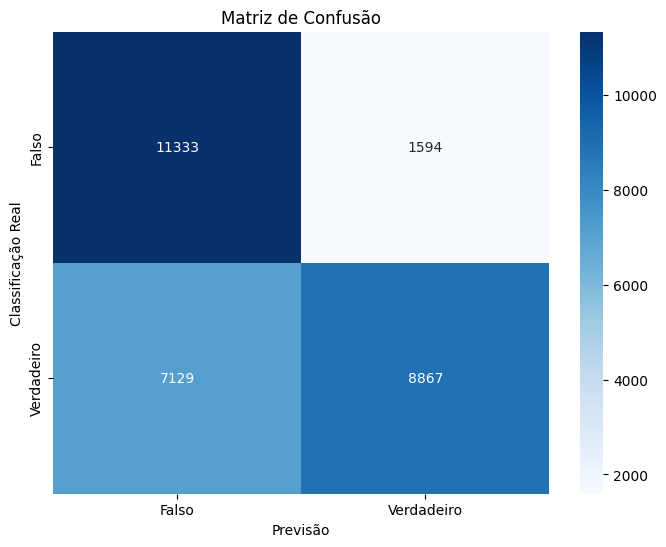

In [12]:
from sklearn.metrics import confusion_matrix  # Importação da função confusion_matrix para calcular a matriz de confusão
import matplotlib.pyplot as plt  # Importação da biblioteca Matplotlib para visualização
import seaborn as sns  # Importação da biblioteca Seaborn para criação de gráficos mais atraentes

# Obtendo as previsões e rótulos verdadeiros para as frames
predicted_labels = df_frames['score'] > 0
true_labels = df_frames['label']

# Calculando a matriz de confusão.
confusion = confusion_matrix(true_labels, predicted_labels)

# Configurando a exibição da matriz de confusão usando um heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Falso', 'Verdadeiro'], yticklabels=['Falso', 'Verdadeiro'])
plt.xlabel('Previsão')
plt.ylabel('Classificação Real')
plt.title('Matriz de Confusão')

# Salvar a imagem da matriz de confusão como um arquivo PNG
plt.savefig(f'{result_net}_matriz_confusao_frames.png')

# Exibe a imagem da matriz de confusão
plt.show()


* **Matriz confusão com as porcentagens**

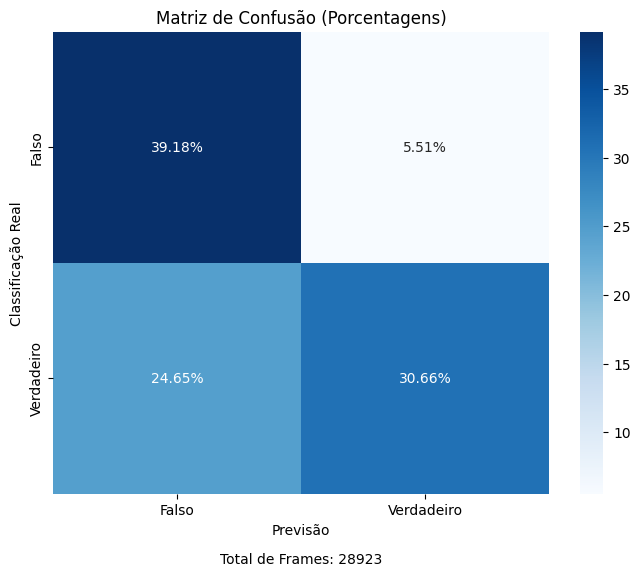

In [13]:
from sklearn.metrics import confusion_matrix  # Importação da função confusion_matrix para calcular a matriz de confusão
import matplotlib.pyplot as plt  # Importação da biblioteca Matplotlib para visualização
import seaborn as sns  # Importação da biblioteca Seaborn para criação de gráficos mais atraentes

# Obtendo as previsões e rótulos verdadeiros para as frames
predicted_labels = df_frames['score'] > 0
true_labels = df_frames['label']

# Calculando a matriz de confusão.
confusion = confusion_matrix(true_labels, predicted_labels)

# Calculando as porcentagens de cada célula da matriz de confusão
total_samples = len(true_labels)
confusion_percentage = confusion / total_samples * 100

# Formatando a matriz de confusão como strings com o símbolo '%' e nenhum formato
confusion_strings = [["{:.2f}%".format(item) for item in row] for row in confusion_percentage]

# Exibindo a matriz de confusão usando um heatmap com os valores formatados
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_percentage, annot=confusion_strings, fmt='', cmap='Blues',
            xticklabels=['Falso', 'Verdadeiro'], yticklabels=['Falso', 'Verdadeiro'])
plt.xlabel('Previsão')
plt.ylabel('Classificação Real')
plt.title('Matriz de Confusão (Porcentagens)')

# Adicionando a quantidade total de frames abaixo da matriz
plt.annotate(f'Total de Frames: {total_samples}', (0.5, -0.15), xycoords='axes fraction', ha='center')

# Salvar a imagem da matriz de confusão em porcentagem como um arquivo PNG
plt.savefig(f'{result_net}_matriz_confusao_porcentagem.png')

# Exibe a imagem da matriz de confusão em porcentagem
plt.show()


* **Métricas importantes**



In [14]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

# Obtendo os valores da matriz de confusão
TN, FP, FN, TP = confusion.ravel()

# Calculando as métricas
accuracy = (TP + TN) / (TP + TN + FP + FN)  # Acurácia
precision = TP / (TP + FP)  # Precisão
recall = TP / (TP + FN)  # Recall (Sensibilidade)
specificity = TN / (TN + FP)  # Especificidade
f1 = 2 * (precision * recall) / (precision + recall)  # F1 Score
roc_auc = roc_auc_score(true_labels, predicted_labels)  # Área sob a curva ROC (AUC-ROC)

# Imprimindo as métricas
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")


Accuracy: 0.6984
Precision: 0.8476
Recall (Sensitivity): 0.5543
Specificity: 0.8767
F1 Score: 0.6703
AUC-ROC: 0.7155


* **Gráfico da curva ROC**



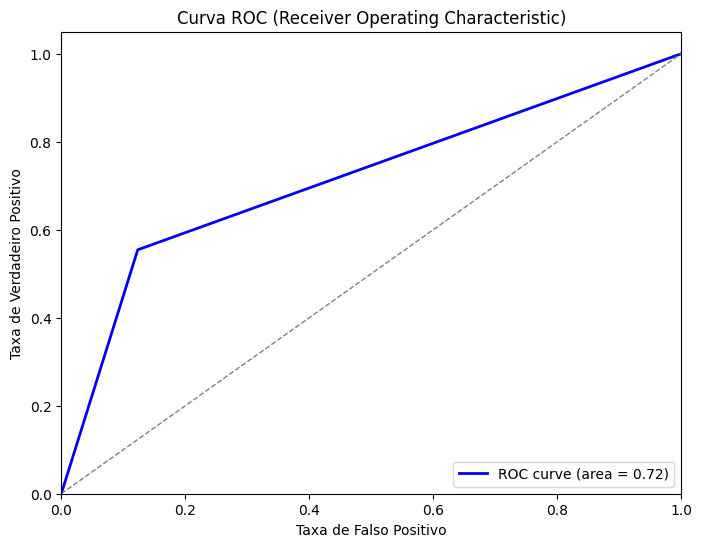

Accuracy: 0.6984
Precision: 0.8476
Recall (Sensitivity): 0.5543
Specificity: 0.8767
F1 Score: 0.6703
AUC-ROC: 0.7155


In [15]:
import matplotlib.pyplot as plt  # Importação da biblioteca Matplotlib para visualização
from sklearn.metrics import roc_curve  # Importação da função roc_curve para calcular a curva ROC

# Obtendo os valores da matriz de confusão
TN, FP, FN, TP = confusion.ravel()

# Calculando as métricas
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)
roc_auc = roc_auc_score(true_labels, predicted_labels)

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)

# Plotando a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')

# Salvar a imagem da curva ROC como um arquivo PNG
plt.savefig(f'{result_net}_ROC.png')

# Exibe a curva ROC
plt.show()

# Imprimindo as métricas
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
